In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 459044, done.
remote: Counting objects: 100% (39503/39503), done.
remote: Compressing objects: 100% (1823/1823), done.
remote: Total 459044 (delta 37668), reused 39403 (delta 37621), pack-reused 419541
Receiving objects: 100% (459044/459044), 901.47 MiB | 34.29 MiB/s, done.
Resolving deltas: 100% (426771/426771), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as ET

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from PIL import Image

In [ ]:
# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


In [ ]:
files_dir = "/content/drive/MyDrive/POLE_AI_PROJECT/clean_imgs"
#/usr/users/multiviewprojections/el_mas/clean_imgs" ####### Directory to change where you put your images of lungs


import os
import cv2
import torch
import numpy as np

class LidcIdri(torch.utils.data.Dataset):
    def __init__(self, files_dir, width, height, transforms=None):
        self.files_dir = files_dir
        self.transforms = transforms
        self.height = height
        self.width = width

        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image.endswith('.png')]
        self.classes = ['0', '1']  # '0' is associated with Nodule and '1' when there is no Nodule

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # Reading the images and resizing
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0

        # Annotation file
        annot_filename = img_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        # Your existing code for opening the annotation file and reading the line

        with open(annot_file_path, 'r') as txt_file:
            line = txt_file.readline()
            parts = line.split()
            class_label = parts[0]

            # Updated line to avoid 'numpy.float64' object is not callable error
            xmin, ymin, xmax, ymax = [int(float(val)) for val in parts[2:6]]

            print(f"Before correction - xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

            # Check if x_max is less than or equal to x_min and handle the situation
            if xmax <= xmin:
                print(f"Before correction - Invalid bounding box coordinates: x_max <= x_min. Image: {image_id}")
                print(f"Before correction - Bounding box coordinates: xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
                xmax = xmin + max(10, xmax - xmin + 1)  # Add 10 or make x_max greater than x_min
                print(f"After correction - Bounding box coordinates: xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

            # Check if y_max is less than or equal to y_min and handle the situation
            if ymax <= ymin:
                print(f"Before correction - Invalid bounding box coordinates: y_max <= y_min. Image: {image_id}")
                print(f"Before correction - Bounding box coordinates: xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
                ymax += 10  # Add 10 to y_max
                print(f"After correction - Bounding box coordinates: xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

            if xmax <= xmin or ymax <= ymin:
                print(f"After correction - Invalid bounding box coordinates for image {image_id}. Skipping...")
            else:
                # Process the bounding box
                # Your remaining code here

                # Correct bounding box coordinates for image size
                xmin_corr = (xmin / img.shape[1]) * self.width
                xmax_corr = (xmax / img.shape[1]) * self.width
                ymin_corr = (ymin / img.shape[0]) * self.height
                ymax_corr = (ymax / img.shape[0]) * self.height


        boxes = [[xmin_corr, ymin_corr, xmax_corr, ymax_corr]]
        labels = [int(class_label)]

        # Convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Getting the area of the box
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "area": area,
            "iscrowd": iscrowd,
            "image_id": torch.tensor([idx]),
        }

        if self.transforms:
            sample = self.transforms(image=img_res, bboxes=target['boxes'], labels=labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    def __len__(self):
        return len(self.imgs)


files_dir = "/content/drive/MyDrive/POLE_AI_PROJECT/clean_imgs" #train with only 20 images
#files_dir = "/usr/users/multiviewprojections/el_mas/clean_imgs"   ####### Directory to change where you put your images of lungs
# check dataset
dataset = LidcIdri(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[23]
print(img.shape, '\n',target)

length of dataset =  1000 

Before correction - xmin: 242, ymin: 163, xmax: 282, ymax: 187
(224, 224, 3) 
 {'boxes': tensor([[140.8000,  94.8364, 164.0727, 108.8000]]), 'labels': tensor([1]), 'area': tensor([324.9719]), 'iscrowd': tensor([0]), 'image_id': tensor([23])}


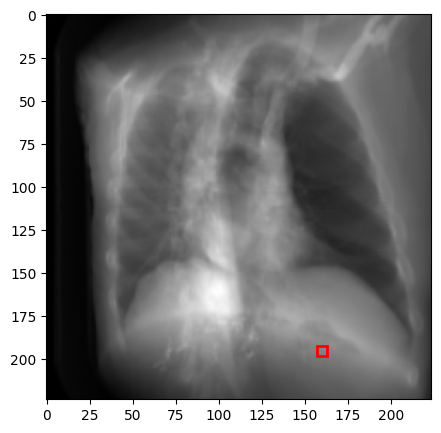

In [ ]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()


# plotting the image with bboxes. Feel free to change the index
img, target = dataset[106]
plot_img_bbox(img, target)

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# use our dataset and defined transformations
dataset = LidcIdri(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = LidcIdri(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def find_bounding_box_coordinates(coordinates):
    if not coordinates:
        return None

    min_x = min(coord[0] for coord in coordinates)
    min_y = min(coord[1] for coord in coordinates)
    max_x = max(coord[0] for coord in coordinates)
    max_y = max(coord[1] for coord in coordinates)

    bottom_left = (min_x, min_y)
    top_right = (max_x, max_y)

    return bottom_left, top_right

# Example usage:
coordinates = [(1, 2), (5, 7), (3, 1), (8, 4)]
bottom_left, top_right = find_bounding_box_coordinates(coordinates)

print("Bottom-left:", bottom_left)
print("Top-right:", top_right)


Bottom-left: (1, 1)
Top-right: (8, 7)


In [ ]:
def order_coordinates(p0, p1, p2, p3):
    # Check X coordinate for p0 and p1
    if p0[0] < p1[0]:
        topleft, topright = p0, p1
    else:
        topleft, topright = p1, p0

    # Check X coordinate for p2 and p3
    if p2[0] < p3[0]:
        bottomleft, bottomright = p2, p3
    else:
        bottomleft, bottomright = p3, p2

    return topleft, topright, bottomleft, bottomright

# Example usage:
p0 = (1, 2)
p1 = (5, 2)
p2 = (1, 6)
p3 = (5, 6)

topleft, topright, bottomleft, bottomright = order_coordinates(p0, p1, p2, p3)

print("Top-left:", topleft)
print("Top-right:", topright)
print("Bottom-left:", bottomleft)
print("Bottom-right:", bottomright)


Top-left: (1, 2)
Top-right: (5, 2)
Bottom-left: (1, 6)
Bottom-right: (5, 6)


Top-left: (1, 2)
Top-right: (5, 7)
Bottom-left: (3, 1)
Bottom-right: (8, 4)


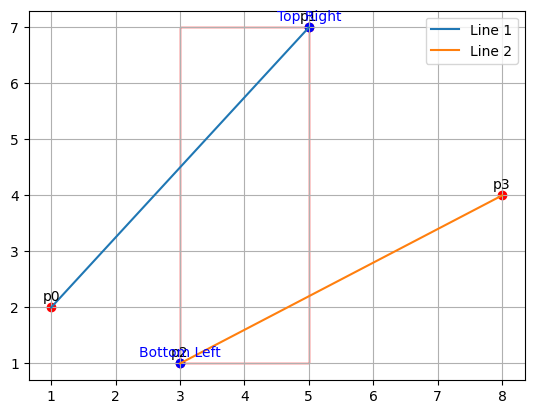

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_coordinates_and_rectangle(p0, p1, p2, p3, bottom_left, top_right):
    fig, ax = plt.subplots()

    # Plot the lines connecting the coordinates
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]], label='Line 1')
    plt.plot([p2[0], p3[0]], [p2[1], p3[1]], label='Line 2')

    # Mark the ordered coordinates
    plt.scatter(*zip(p0, p1, p2, p3), color='red')

    # Add labels for the ordered coordinates
    for i, txt in enumerate(['p0', 'p1', 'p2', 'p3']):
        plt.annotate(txt, (eval(f'p{i}')[0], eval(f'p{i}')[1]), textcoords="offset points", xytext=(0,5), ha='center')

    # Plot the rectangle
    width = top_right[0] - bottom_left[0]
    height = top_right[1] - bottom_left[1]
    rectangle = patches.Rectangle(bottom_left, width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rectangle)

    # Mark the points of the rectangle
    plt.scatter(*zip(bottom_left, top_right), color='blue')

    # Add labels for the rectangle points
    for point, txt in zip([bottom_left, top_right], ['Bottom Left', 'Top Right']):
        plt.annotate(txt, (point[0], point[1]), textcoords="offset points", xytext=(0,5), ha='center', color='blue')

    plt.legend()
    plt.grid(True)
    plt.show()

# Example coordinates
coordinates = [(1, 2), (5, 7), (3, 1), (8, 4)]
p0, p1, p2, p3 = coordinates

# Example rectangle points
bottom_left = (3, 1)
top_right = (5, 7)

# Order coordinates
topleft, topright, bottomleft, bottomright = order_coordinates(p0, p1, p2, p3)

print("Top-left:", topleft)
print("Top-right:", topright)
print("Bottom-left:", bottomleft)
print("Bottom-right:", bottomright)

# Plot both coordinates and rectangle on the same graph
plot_coordinates_and_rectangle(p0, p1, p2, p3, bottom_left, top_right)


We use NonMax Suppression to avoid predicting many boxes per image

## Testing our Model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as ET

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from PIL import Image


# In[2]:


# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


# In[3]:


files_dir = "/content/drive/MyDrive/POLE_AI_PROJECT/clean_imgs"
#/usr/users/multiviewprojections/el_mas/clean_imgs" ####### Directory to change where you put your images of lungs


import os
import cv2
import torch
import numpy as np

class LidcIdri(torch.utils.data.Dataset):
    def __init__(self, files_dir, width, height, transforms=None):
        self.files_dir = files_dir
        self.transforms = transforms
        self.height = height
        self.width = width

        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image.endswith('.png')]
        self.classes = ['0', '1']  # '0' is associated with Nodule and '1' when there is no Nodule

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # Reading the images and resizing
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0

        # Annotation file
        annot_filename = img_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.files_dir, annot_filename)


        with open(annot_file_path, 'r') as txt_file:
            line = txt_file.readline()
            parts = line.split()
            class_label = parts[0]

            # Corrected line to handle 'numpy.float64' object is not callable error
            xmin, ymin, xmax, ymax = [int(float(val)) for val in parts[2:6]]

            if xmax <= xmin:
                xmax = xmin + 10

            if ymax <= ymin:
                ymax = ymin + 10

            # Correct bounding box coordinates for image size
            xmin_corr = (xmin / img.shape[1]) * self.width
            xmax_corr = (xmax / img.shape[1]) * self.width
            ymin_corr = (ymin / img.shape[0]) * self.height
            ymax_corr = (ymax / img.shape[0]) * self.height

        boxes = [[xmin_corr, ymin_corr, xmax_corr, ymax_corr]]
        labels = [int(class_label)]

        # Convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Getting the area of the box
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "area": area,
            "iscrowd": iscrowd,
            "image_id": torch.tensor([idx]),
        }

        if self.transforms:
            sample = self.transforms(image=img_res, bboxes=target['boxes'], labels=labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    def __len__(self):
        return len(self.imgs)







# In[4]:


def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()





# In[5]:


def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


# In[6]:


def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# In[7]:


# use our dataset and defined transformations
dataset = LidcIdri(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = LidcIdri(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)


# In[8]:


print(torch.cuda.is_available())


# In[11]:


def find_bounding_box_coordinates(coordinates):
    if not coordinates:
        return None

    min_x = min(coord[0] for coord in coordinates)
    min_y = min(coord[1] for coord in coordinates)
    max_x = max(coord[0] for coord in coordinates)
    max_y = max(coord[1] for coord in coordinates)

    bottom_left = (min_x, min_y)
    top_right = (max_x, max_y)

    return bottom_left, top_right





# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


import torch


# In[16]:

from torch.utils.tensorboard import SummaryWriter
import os
import torch
import torchvision



# Create a 'logs' directory if it doesn't exist
logs_dir = 'logs'
os.makedirs(logs_dir, exist_ok=True)

# create a SummaryWriter inside the 'logs' directory
writer = SummaryWriter(log_dir=os.path.join(logs_dir, 'tensorboard_logs'))

# training for 10 epochs
num_epochs = 20
iou_accumulator = 0.0
map_accumulator = 0.0

for epoch in range(num_epochs):
    # Training for one epoch
    total_loss = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    print(f'Total Loss at Epoch {epoch}: {total_loss}')



    # Update the learning rate
    lr_scheduler.step()


# close the SummaryWriter
writer.close()


def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')


# pick one image from the test set
img, target = dataset_test[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))



True


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 140MB/s]


cuda
Epoch: [0]  [ 0/80]  eta: 0:11:32  lr: 0.000068  loss: 1.4114 (1.4114)  loss_classifier: 0.8315 (0.8315)  loss_box_reg: 0.0016 (0.0016)  loss_objectness: 0.5605 (0.5605)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 8.6551  data: 4.7457  max mem: 8221
Epoch: [0]  [10/80]  eta: 0:05:53  lr: 0.000701  loss: 0.7339 (0.8441)  loss_classifier: 0.3404 (0.4014)  loss_box_reg: 0.0015 (0.0015)  loss_objectness: 0.4061 (0.4232)  loss_rpn_box_reg: 0.0175 (0.0180)  time: 5.0469  data: 3.1198  max mem: 8381
Epoch: [0]  [20/80]  eta: 0:03:32  lr: 0.001333  loss: 0.2906 (0.5436)  loss_classifier: 0.0350 (0.2242)  loss_box_reg: 0.0015 (0.0036)  loss_objectness: 0.2357 (0.2996)  loss_rpn_box_reg: 0.0151 (0.0162)  time: 3.2852  data: 1.5629  max mem: 8381
Epoch: [0]  [30/80]  eta: 0:02:31  lr: 0.001965  loss: 0.1881 (0.4268)  loss_classifier: 0.0350 (0.1669)  loss_box_reg: 0.0071 (0.0049)  loss_objectness: 0.1251 (0.2395)  loss_rpn_box_reg: 0.0143 (0.0155)  time: 1.9085  data: 0.1737  max mem: 8381
Epo

In [ ]:
model_save_path = 'trained_model_1.pth'
torch.save(model.state_dict(), model_save_path)

In [ ]:

def calculate_iou(boxA, boxB):
    # Calculate the Intersection over Union (IoU) of two bounding boxes
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = inter_area / float(boxA_area + boxB_area - inter_area)

    return iou


In [ ]:

def compute_mIoU(model, data_loader, device):

    mIoU = 0.0
    total_samples = 0

    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            predictions = model(images)

        for i in range(len(targets)):
            target_boxes = targets[i]['boxes'].cpu().numpy()
            pred_boxes = predictions[i]['boxes'].cpu().numpy()
            ious = []

            for pred_box in pred_boxes:
                for target_box in target_boxes:
                    iou = calculate_iou(pred_box, target_box)
                    ious.append(iou)

            if ious:
                mIoU += max(ious)
                total_samples += 1

    if total_samples == 0:
        return 0.0

    return mIoU / total_samples

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_predictions(model, data_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            if i >= num_images:
                break

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            # Assuming outputs is a list of dictionaries (each dictionary corresponds to one image)
            for j, output in enumerate(outputs):
                image = images[j].permute(1, 2, 0).cpu().numpy()
                boxes = output['boxes'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                scores = output['scores'].cpu().numpy()

                plt.imshow(image)

                ax = plt.gca()

                # Display ground truth boxes in green
                for box in targets[j]['boxes']:
                    box = box.cpu().numpy()
                    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='g', facecolor='none')
                    ax.add_patch(rect)

                # Display predicted boxes in red
                for box, label, score in zip(boxes, labels, scores):
                    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    plt.text(box[0], box[1], f'Class {label} | Score: {score:.3f}', color='r')

                plt.show()

# Call the function to display predictions for 5 images
display_predictions(model, data_loader_test, device, num_images=5)


In [ ]:
import os
import json

def convert_to_coco_format(annotations_folder, output_json_path):
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "category_name"}],  # Adjust category information as needed
    }

    image_id = 0
    annotation_id = 0

    for filename in os.listdir(annotations_folder):
        if filename.endswith(".txt"):
            # Read your custom annotation file format and extract bounding box information
            with open(os.path.join(annotations_folder, filename), 'r') as file:
                lines = file.readlines()
                # Extract information as needed from your custom format
                # For example, assuming your format is: label, xmin, ymin, xmax, ymax, confidence, score1, score2, score3
                label, _, xmin, ymin, xmax, ymax, _, _, _ = map(float, lines[0].split())

                image_info = {
                    "id": image_id,
                    "file_name": filename.replace(".txt", ".png"),  # Adjust the extension based on your image format
                    "height":385,  # Replace with the actual image height
                    "width":385,  # Replace with the actual image width
                }

                annotation_info = {
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": int(label),  # Assuming label is an integer
                    "bbox": [xmin, ymin, xmax - xmin, ymax - ymin],  # COCO format [x, y, width, height]
                    "area": (xmax - xmin) * (ymax - ymin),
                    "iscrowd": 0,
                }

                coco_data["images"].append(image_info)
                coco_data["annotations"].append(annotation_info)

                image_id += 1
                annotation_id += 1

    with open(output_json_path, 'w') as json_file:
        json.dump(coco_data, json_file)

# Specify the path to your annotations folder and the desired output JSON path
annotations_folder = "/content/drive/MyDrive/POLE_AI_PROJECT/clean_imgs"
output_json_path = "/content/drive/MyDrive/POLE_AI_PROJECT/coco_annotations.json"

# Convert annotations to COCO format
convert_to_coco_format(annotations_folder, output_json_path)


In [ ]:
from pycocotools.cocoeval import COCOeval
import torch

def compute_map_iou(model, data_loader, device):
    model.eval()

    # Create COCO instances for ground truth and results
    coco_gt = COCO("/content/drive/MyDrive/POLE_AI_PROJECT/coco_annotations.json")  # Replace with the actual path
    coco_results = []

    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images)

        # Apply NMS and convert predictions to COCO format
        for i, output in enumerate(outputs):
            prediction = apply_nms(output)
            boxes = prediction["boxes"].cpu().numpy()
            scores = prediction["scores"].cpu().numpy()
            labels = prediction["labels"].cpu().numpy()

            image_id = coco_gt.getImgIds(imgIds=[i])[0]
            coco_results.extend(
                [
                    {"image_id": image_id, "category_id": int(labels[j]), "bbox": boxes[j], "score": scores[j]}
                    for j in range(len(boxes))
                ]
            )

    # Load detections to COCO result object
    coco_dt = coco_gt.loadRes(coco_results)

    # Create COCOeval object
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()


compute_map_iou(model, data_loader_test, device)
# Replace "path/to/your/annotations/coco_annotations.json" with the actual path to your COCO-style annotation file.
